In [2]:
import tensorflow as tf
from tensorflow import keras
import os
import sys
import matplotlib.pyplot as plt

project_root = os.path.abspath('..')
if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [3]:
glioma_path = '/Users/alex/Desktop/NeuroRex/data/mri_tumor_classifier/glioma'
meningioma_path = '/Users/alex/Desktop/NeuroRex/data/mri_tumor_classifier/meningioma'
pituitary_path = '/Users/alex/Desktop/NeuroRex/data/mri_tumor_classifier/pituitary'
notumor_path = '/Users/alex/Desktop/NeuroRex/data/mri_tumor_classifier/notumor'

In [4]:
def decode_image(file_path, image_data):
    ext = tf.strings.lower(tf.strings.split(file_path, '.')[-1])
    
    def decode_jpg():
        return tf.image.decode_jpeg(image_data, channels=3)
    
    def decode_png():
        return tf.image.decode_png(image_data, channels=3)
    
    return tf.case([
        (tf.equal(ext, 'jpeg'), decode_jpg),
        (tf.equal(ext, 'jpg'), decode_jpg),
        (tf.equal(ext, 'png'), decode_png),
    ], exclusive=True, default=decode_jpg)

In [5]:
IMG_SIZE = (224, 224)

def process_path(file_path, label):
    image_data = tf.io.read_file(file_path)
    image = decode_image(file_path, image_data)
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.cast(image, tf.float32)/255.0
    
    return image, label

In [ ]:
glioma_files = [os.path.join(glioma_path, f) for f in os.listdir(glioma_path) if f.lower().endswith(('.jpg','.jpeg','.png'))]
meningioma_files = [os.path.join(meningioma_path, f) for f in os.listdir(meningioma_path) if f.lower().endswith(('.jpg','.jpeg','.png'))]
pituitary_files = [os.path.join(pituitary_path, f) for f in os.listdir(pituitary_path) if f.lower().endswith(('.jpg','.jpeg','.png'))]
notumor_files = [os.path.join(notumor_path, f) for f in os.listdir(notumor_path) if f.lower().endswith(('.jpg','.jpeg','.png'))]

In [7]:
all_files = glioma_files+meningioma_files+pituitary_files+notumor_files
all_labels = len(glioma_files)*[0]+len(meningioma_files)*[1]+len(pituitary_files)*[2]+len(notumor_files)*[3]

In [8]:
from sklearn.model_selection import train_test_split

train_data, temp_data, train_labels, temp_labels = train_test_split(all_files, all_labels, test_size=0.2, random_state=42, stratify=all_labels)
val_data, test_data, val_labels, test_labels = train_test_split(temp_data, temp_labels, test_size=0.5, random_state=42, stratify=temp_labels)

In [9]:
def make_dataset(data, labels, shuffle=True, batch_size=32):
    dataset = tf.data.Dataset.from_tensor_slices((data, labels))
    dataset = dataset.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        dataset = dataset.shuffle(1000)
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

In [10]:
train_ds = make_dataset(train_data, train_labels)
val_ds = make_dataset(val_data, val_labels, shuffle=False)
test_ds = make_dataset(test_data, test_labels, shuffle=False)

2025-04-25 13:08:31.053543: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-04-25 13:08:31.053575: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-04-25 13:08:31.053587: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-04-25 13:08:31.053870: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-25 13:08:31.054090: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [11]:
from models.mri_tumor_classifier.cnn_model import mri_tumor_classifier

model = mri_tumor_classifier()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0     

In [12]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_names = [0, 1, 2, 3]
unique_classes = np.unique(train_labels)
class_weight = compute_class_weight(class_weight='balanced', classes=unique_classes, y = train_labels)

In [13]:
class_weight_dict = dict(enumerate(class_weight))
print(class_weight_dict)

{0: 1.0828835774865073, 1: 1.0672492401215805, 2: 0.999644128113879, 3: 0.8778125}


In [14]:
model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(1e-4),
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [15]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

In [16]:
history_1 = model.fit(
    train_ds, 
    validation_data=val_ds, 
    epochs = 20, 
    class_weight=class_weight_dict,
    callbacks=[early_stop]
)

Epoch 1/20


2025-04-25 13:08:34.674452: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


176/176 [==============================] - 35s 174ms/step - loss: 0.8993 - accuracy: 0.7013 - val_loss: 0.3387 - val_accuracy: 0.8704
Epoch 2/20
176/176 [==============================] - 30s 166ms/step - loss: 0.5304 - accuracy: 0.8343 - val_loss: 0.2379 - val_accuracy: 0.9160
Epoch 3/20
176/176 [==============================] - 31s 172ms/step - loss: 0.3976 - accuracy: 0.8772 - val_loss: 0.2970 - val_accuracy: 0.8989
Epoch 4/20
176/176 [==============================] - 30s 168ms/step - loss: 0.3264 - accuracy: 0.9094 - val_loss: 0.1843 - val_accuracy: 0.9430
Epoch 5/20
176/176 [==============================] - 30s 165ms/step - loss: 0.1942 - accuracy: 0.9350 - val_loss: 0.1602 - val_accuracy: 0.9373
Epoch 6/20
176/176 [==============================] - 30s 167ms/step - loss: 0.1503 - accuracy: 0.9486 - val_loss: 0.1600 - val_accuracy: 0.9501
Epoch 7/20
176/176 [==============================] - 30s 166ms/step - loss: 0.1170 - accuracy: 0.9601 - val_loss: 0.0939 - val_accuracy: 0.9

In [17]:
model.evaluate(test_ds)

22/22 [==============================] - 4s 157ms/step - loss: 0.1093 - accuracy: 0.9644


[0.10927373170852661, 0.9644381403923035]

In [19]:
model.save('/Users/alex/Desktop/NeuroRex/models/mri_tumor_classifier/mobilenetv2_mriclass.keras')

1/1 [==============================] - 0s 151ms/step


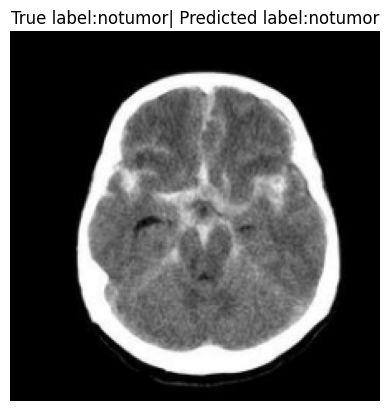

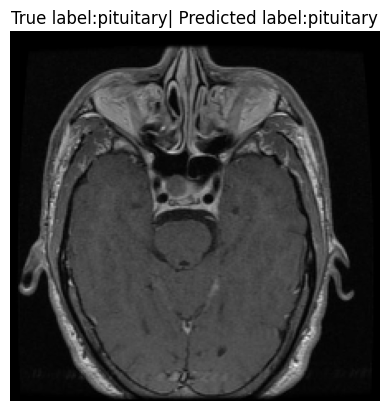

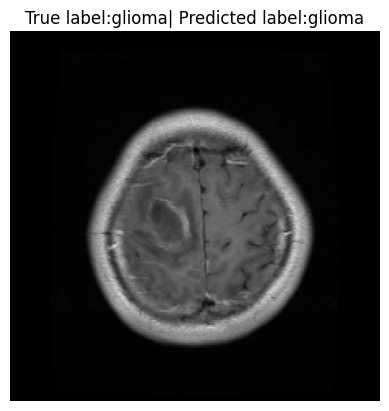

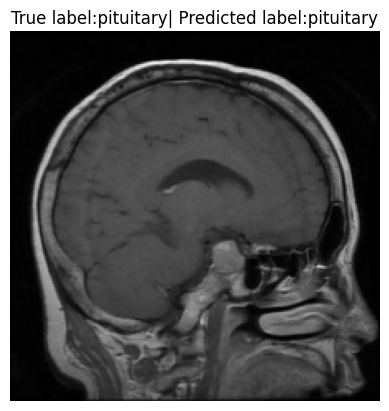

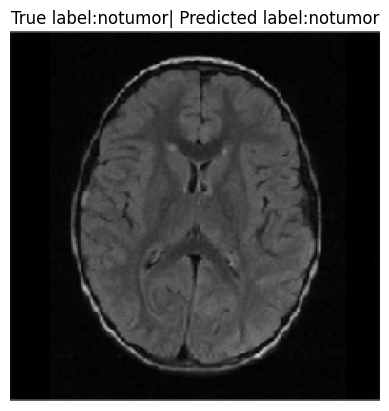

In [22]:
CLASS_LABELS = {
    0:'glioma',
    1:'meningioma',
    2:'pituitary',
    3:'notumor'
}
for images,labels in test_ds.take(1):
    preds = model.predict(images)
    preds = tf.argmax(preds, axis=1)
    
for i in range(5):
    plt.imshow(images[i])
    plt.title(f"True label:{CLASS_LABELS[labels[i].numpy()]}| Predicted label:{CLASS_LABELS[preds[i].numpy()]}")
    plt.axis('off')
    plt.show()